⏳ Đang tải model...
✅ Tải model thành công! Các lớp model nhận diện được: {0: 'boots', 1: 'gloves', 2: 'goggles', 3: 'helmet', 4: 'no-boots', 5: 'no-gloves', 6: 'no-goggles', 7: 'no-helmet', 8: 'no-vest', 9: 'vest'}

📸 Tìm thấy 5 ảnh. Bắt đầu xử lý...

--- Đang kiểm tra: Check ảnh 1.jpg ---
✅ AN TOÀN: Phát hiện 2 người đang đội nón (HELMET).


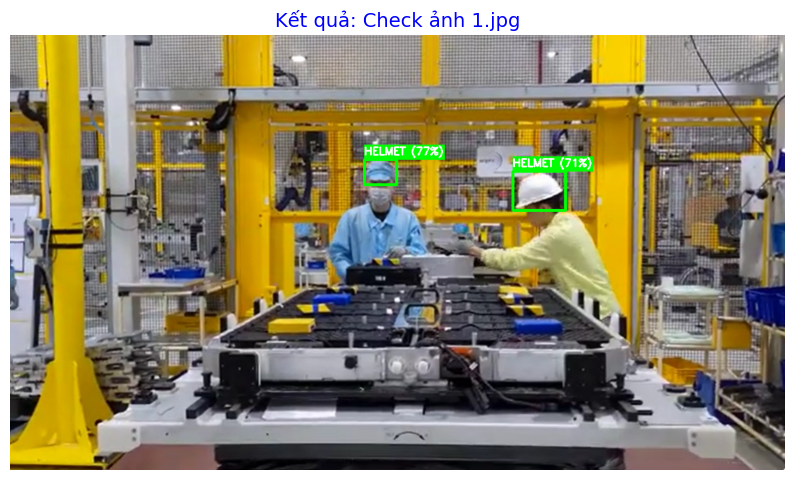

--- Đang kiểm tra: Check ảnh 2.jpg ---
⚠️ Không tìm thấy người đội nón trong ảnh.


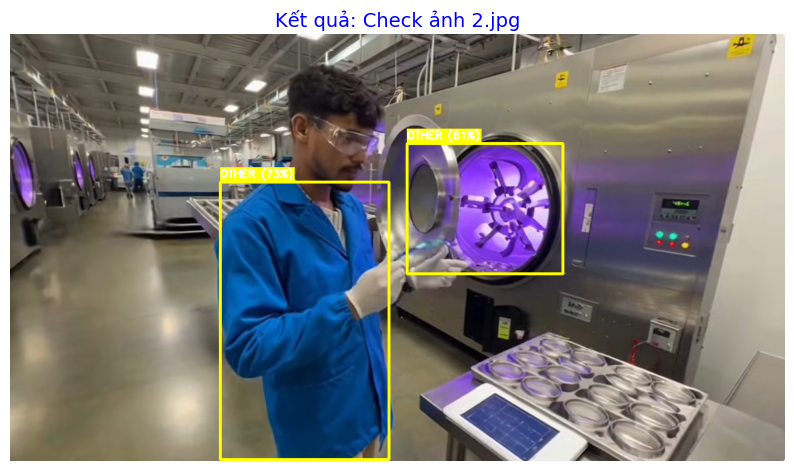

--- Đang kiểm tra: Check ảnh 3.jpg ---
⚠️ Không tìm thấy người đội nón trong ảnh.


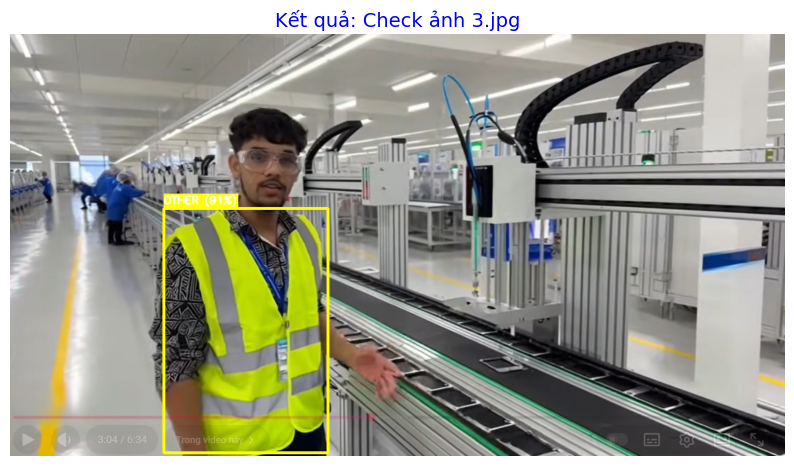

--- Đang kiểm tra: Check ảnh 4.jpg ---
⚠️ Không tìm thấy người đội nón trong ảnh.


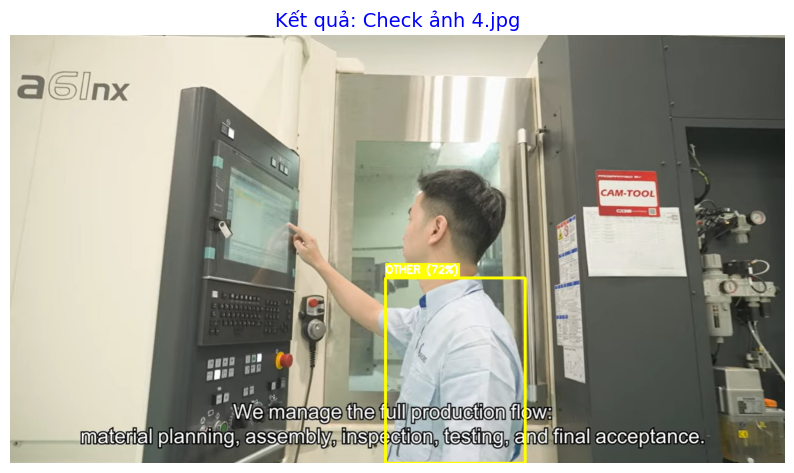

--- Đang kiểm tra: Check ảnh 5.jpg ---
✅ AN TOÀN: Phát hiện 1 người đang đội nón (HELMET).


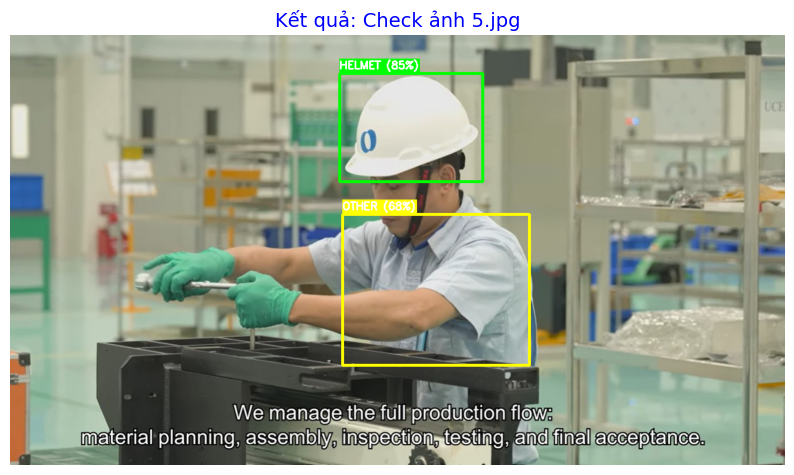


🎉 HOÀN TẤT.


In [ ]:
import sys
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

# ==============================================================================
# 1. CẤU HÌNH (Bạn chỉ cần sửa phần này nếu cần)
# ==============================================================================
# Đường dẫn đến thư mục chứa ảnh
raw_path = r"D:\THS\06.1 Python\AI Camera"
WORK_DIR = Path(raw_path)

# Các từ khóa để nhận biết (Viết thường hết để so sánh cho dễ)
# Nhóm AN TOÀN (Sẽ tô màu XANH)
KEYWORDS_SAFE = ['helmet', 'hardhat', 'safety', 'cap', 'casque'] 

# Nhóm NGUY HIỂM (Sẽ tô màu ĐỎ)
KEYWORDS_UNSAFE = ['no-helmet', 'no_helmet', 'head', 'face', 'person', 'no hardhat']

# ==============================================================================
# 2. HÀM KIỂM TRA & VẼ
# ==============================================================================
def get_safety_status(class_name):
    """
    Hàm xác định xem tên lớp này thuộc nhóm An toàn hay Nguy hiểm
    Trả về: (Trạng thái, Màu sắc BGR)
    """
    name_lower = class_name.lower()
    
    # 1. Kiểm tra nhóm An toàn trước
    for kw in KEYWORDS_SAFE:
        if kw in name_lower:
            return "HELMET", (0, 255, 0) # Màu Xanh lá (Green)

    # 2. Kiểm tra nhóm Nguy hiểm
    for kw in KEYWORDS_UNSAFE:
        if kw in name_lower:
            return "NO-HELMET", (0, 0, 255) # Màu Đỏ (Red)
            
    # 3. Khác (Không xác định) -> Màu vàng
    return "OTHER", (0, 255, 255)

# ==============================================================================
# 3. CHƯƠNG TRÌNH CHÍNH
# ==============================================================================
# Tìm file model
model_path = WORK_DIR / "best.pt"
if not model_path.exists():
    print("❌ Lỗi: Không tìm thấy file best.pt")
    sys.exit()

print("⏳ Đang tải model...")
try:
    model = YOLO(str(model_path))
    print(f"✅ Tải model thành công! Các lớp model nhận diện được: {model.names}")
except Exception as e:
    print(f"❌ Lỗi load model: {e}")
    sys.exit()

# Tìm ảnh
image_files = list(WORK_DIR.glob('*.jpg')) + list(WORK_DIR.glob('*.png')) + list(WORK_DIR.glob('*.jpeg'))

if not image_files:
    print("⚠️ Không tìm thấy ảnh nào để kiểm tra.")
else:
    print(f"\n📸 Tìm thấy {len(image_files)} ảnh. Bắt đầu xử lý...\n")

    for img_file in image_files:
        # Đọc ảnh
        img = cv2.imread(str(img_file))
        if img is None:
            continue
            
        print(f"--- Đang kiểm tra: {img_file.name} ---")
        
        # Nhận diện
        results = model.predict(source=img, conf=0.5, verbose=False)
        result = results[0]
        
        # Biến đếm để tổng kết
        count_helmet = 0
        count_no_helmet = 0
        
        # Duyệt qua từng vật thể
        for box in result.boxes:
            # Lấy thông tin tọa độ và lớp
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            cls_name = model.names[cls_id]
            conf = float(box.conf[0])
            
            # Xác định trạng thái và màu sắc
            status_text, color = get_safety_status(cls_name)
            
            # Thống kê
            if status_text == "HELMET":
                count_helmet += 1
            elif status_text == "NO-HELMET":
                count_no_helmet += 1
                
            # --- VẼ LÊN ẢNH ---
            # 1. Vẽ khung chữ nhật
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
            
            # 2. Vẽ nhãn (Tạo nền chữ cho dễ đọc)
            label = f"{status_text} ({conf:.0%})"
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(img, (x1, y1 - 25), (x1 + w, y1), color, -1) # Nền màu
            cv2.putText(img, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # IN KẾT QUẢ RA MÀN HÌNH
        if count_no_helmet > 0:
            print(f"❌ CẢNH BÁO: Có {count_no_helmet} trường hợp KHÔNG đội nón (NO-HELMET)!")
        elif count_helmet > 0:
            print(f"✅ AN TOÀN: Phát hiện {count_helmet} người đang đội nón (HELMET).")
        else:
            print(f"⚠️ Không tìm thấy người đội nón trong ảnh.")

        # HIỂN THỊ ẢNH
        # Chuyển BGR -> RGB để hiện đúng trên Jupyter
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Kết quả: {img_file.name}", fontsize=14, color='blue')
        plt.show()

print("\n🎉 HOÀN TẤT.")